# Clustering Script #
Code Created By: David Kim, Sabine Hutter, Tyler Walker, and Ibrahim Rasheed

This script finds the frequency of chemical types surrounding the isoalloxazine structure for each flavoprotein and clusters them together using KMeans clustering. It will produce a DataFrame with each row representing a flavoprotein and the frequency of chemical types of atoms surrounding the isoalloxazine in each flavoprotein. It will then output a CSV files of the DataFrame. 

This is a "catch-all" script that is meant to be run only once. It will take a large amount of time to run through all flavoprotein PDB files. The CSV output file can be updated with the "Clustering Add-On" script where the user can add any missing flavoprotein without having to run through every single flavoprotein.

To easily run this script, press "<strong>Cell</strong>, then <strong>Run All</strong>"

In [233]:
%matplotlib inline

import pandas as pd
import numpy as np
from biopandas.pdb import PandasPdb as PandasPdb
import csv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy as sp
import scipy.spatial.distance as spd
import scipy.cluster.hierarchy as sph
import sklearn as sk
import sklearn.metrics as skm
import sklearn.cluster as skc
import sklearn.decomposition as skd
import sklearn.mixture as skmix
import sklearn.manifold as manifold
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns

## Global Variables and DataFrame of Flavoproteins ##
This block of code establishes global items that are needed throughout the whole code. It is global for ease of access to avoid having to continually include these variables in every single function. This block of code also creates a DataFrame from a text file of 2500+ Flavoprotein PDB codes. This DataFrame allows the code to analyze all the Flavoproteins automatically instead of the user having to manually enter the PDB code for each flavoprotein. 

In [234]:
key_atoms = ['N1', 'C2', 'O2', 'N3', 'C4', 'O4', 'C4A', 'C4X', 'N5', 'C5A', 'C5X', 'C6', 'C7', 'C7M', 'C8', 'C8M', 'C9', 'C9A', 'N10', 'C10']
key_res = ['FMN', 'FAD']
ambiguous_atom = ['C4A', 'C4X', 'C5A', 'C5X']

#Read in text file containing most of the existing pdb codes of flavoproteins on Protein Data Bank
df_pdbs = pd.read_csv('pdb_codes.txt', sep=" ", header=None)
df_pdbs = df_pdbs.transpose()
df_pdbs.columns = ['pdb']

bioassembly = input("Please enter biological assembly number. Enter 0 if not reading biological assembly: ")
angstrom_limit = float(input("Please enter desired ångström limit: "))

Please enter biological assembly number. Enter 0 if not reading biological assembly: 1
Please enter desired ångström limit: 3.5


## Ambiguous Atom Name Fix ##
In the PDB files, C4A and C4X, as well as C5A and C5X, the 'A' and 'X' label are interchangeable. However, the 'A' and 'X' atoms are not the same. The important one is in the isoalloxazine structure. This function is used to find the index number of N5, an atom in the isoalloxazine structure. By finding the index number for N5, the code can check to see if the 'A' or 'X' atom lies within the isoalloxazine structure by measuring the distance to the N5 atom. 

In [235]:
#Find index number of N5 to check which of the ambiguous atoms are isoalloxazines
def check_ambiguous_atoms(df_hetatm):
    index_N5 = []
    for i in range(len(df_hetatm)): #Use df_hetatm instead of df because distance function reads only separated dataframe
        if df_hetatm.atom_name[i]== 'N5':
            index_N5.append(i)
        else:
            continue
    return(index_N5)

## Removing Irrelevant C1 Atom ##
The isoalloxazine structure is a set, predictable structure. The C1 atom, which is not part of the structure, is also always in the same position. Since the C1 position is already known, it is not needed when gathering distances of surrounding atom/heteroatoms. The purpose of this function is to find the index number of the C1 atom that is attached to the isoalloxazine structure in the dataframe to remove it later on.

In [236]:
#Find index number of C1 to exclude distant between isoalloxazine and C1 atom
def check_c1_atom(df_hetatm):
    index_C1 = []
    for i in range(len(df_hetatm)): #Use df_hetatm instead of df because distance function reads only separated dataframe
        if df_hetatm.atom_name[i] == "C1'":
            index_C1.append(i)
        else:
            continue
    return(index_C1)

## Finding Distances ##
This function finds the distance between the surrounding heteroatoms/atoms and the isoalloxazine. This function takes in two dictionaries and the desired angstrom limit. It uses the Biopandas' distance function to quickly find the distances. This function returns two dictionaries containing the distances between isoalloxzine and atoms/heteroatoms.

In [237]:
def find_distance(df, df_atom, df_hetatm, ppdb, distance_atom_dict, distance_het_dict, angstrom_limit):    
    i = 0
    for i in range(len(df)):
        if ((df.residue_name[i] in key_res) and (df.atom_name[i] in key_atoms)):
            reference_point = (df.x_coord[i], df.y_coord[i], df.z_coord[i])
            distances_atm = ppdb.distance(xyz=reference_point, records='ATOM')
            distances_het = ppdb.distance(xyz=reference_point, records='HETATM')
            for c1 in check_c1_atom(df_hetatm): #Checking to see if C1 atom is in isoalloxazine
                if (df.residue_number[i] == df_hetatm.residue_number[c1]):
                    distances_het = distances_het.drop(c1)
                else:
                    distances_het = distances_het
            if df.atom_name[i] in ambiguous_atom: #Checking to see which ambiguous atom is correct
                for ind in check_ambiguous_atoms(df_hetatm):
                    if distances_het[ind] < 2.0: #If less than 2 Angstroms away, by recommendation of Bruce
                        distance_het_dict[i] = distances_het[distances_het <= angstrom_limit]
                        distance_atom_dict[i] = distances_atm[distances_atm <= angstrom_limit]
                        break
                    else:
                        continue
            else:
                distance_het_dict[i] = distances_het[distances_het <= angstrom_limit]
                distance_atom_dict[i] = distances_atm[distances_atm <= angstrom_limit]
    
    #Remove intra-isoalloxazine distances
    for k,v in distance_het_dict.items():
        for iso in v.index:
            if ((df_hetatm.atom_name[iso] in key_atoms) and (df_hetatm.residue_number[iso] == df.residue_number[k])):
                v = v.drop(iso)
        distance_het_dict[k] = v
        
    #This is to relabel the indices of distance_het_dict from df_hetatm indexes to the combined df indexes
    pairs = {}
    for k,v in distance_het_dict.items():
        lst = []
        if len(v.index) != 0:
            for targ in v.index:
                check_res_numb = df_hetatm.residue_number[targ]
                check_atom_name = df_hetatm.atom_name[targ]
                new_targ = df.index[(df.residue_number == check_res_numb) & (df.atom_name == check_atom_name)]
                lst.append((new_targ.values[0], v[targ]))
            pairs[k] = lst
    
    distance_het_dict = pairs
    
    return (distance_atom_dict, distance_het_dict)

## Create Dataframe ##
This function creates a dataframe of the distance relationship between each atom in the isoalloxazine and its
surrounding atoms and heteroatoms. It also finds the chemical code and type associated with the target atom/heteroatom. 

In [238]:
def distance_dataframe(distance_atom_dict, distance_het_dict, df, df_codes, df_chemicals):
    ref_atom_list = []
    target_atom_list = []
    distance_list = []

    for k,v in distance_atom_dict.items():
        for target, dist in v.iteritems():
            ref_atom_list.append(k)
            target_atom_list.append(target)
            distance_list.append(dist)

    for k,v in distance_het_dict.items():
        for i in v:
            ref_atom_list.append(k)
            target_atom_list.append(i[0])
            distance_list.append(i[1])

    df_dist = pd.DataFrame()
    df_dist['isoalloxazine'] = ref_atom_list
    df_dist['target_atom'] = target_atom_list
    df_dist['distance'] = distance_list
    
    #This is to find the associated chemical code of the target atom/heteroatm
    code_list = []
    for i in df_dist['target_atom']:
        temp = df_codes.index[(df_codes.Residue == df.residue_name[i]) & (df_codes.Atom == df.atom_name[i])]
        if len(temp) != 0:
            code_list.append(df_codes.Code[temp[0]])
        else:
            code_list.append(0) #Every atom is not represented in the code doc Dr. Palfey gave us. 0 for now.

    df_dist['chemical_codes'] = code_list
    
    #This is to find the associated chemical type of the target atom/heteroatm
    chemical_list = []
    for i in df_dist['chemical_codes']:
        temp = df_chemicals.index[df_chemicals.Code == i]
        try:
            chemical_list.append(df_chemicals.Label[temp[0]])
        except:
            chemical_list.append("N/A")
    
    df_dist['chemical_type'] = chemical_list
    
    return(df_dist)

## K-Means Clustering ##
This function runs a K-Means clustering on flavoproteins based on the frequency of chemical types of the atoms surrounding the isoalloxazine structure. The amount of clusters created is derived from the "rule of thumb" method. It takes in the DataFrame that holds the frequency of the chemical types of atoms for each flavoprotein and assigns a K-mean clustering label to each flavoprotein.

In [239]:
def kmeans_cluster(df):
    #Determine amount of clusters
    number_of_cluster = np.round(np.sqrt(len(df)/2))
    
    kmeans_model = skc.KMeans(n_clusters=int(number_of_cluster))
    kmeans_model.fit(df)
    centroids = kmeans_model.cluster_centers_
    
    #Create column for K-means label for each flavoprotein
    df['cluster_labels_kmeans'] = kmeans_model.labels_
    
    return(df)

## Heirarchical Clustering and Dendrogram ##
This function runs a heirarchical clustering on the flavoproteins. They are clustered together based on the frequency of chemical types of the atoms surrounding the isoalloxazine structure in each flavoprotein. This is less priority than K-Means clustering, but it is usually similar to it. It gives a good visual to the amount of clusters that are created. 

In [240]:
#Create a dendrogram using heirarchical clustering
def create_dendrogram(df_value):
    dist_value = spd.squareform(spd.pdist(df_value,metric='euclidean'))
    dist_value.shape
    Z_lang = sph.linkage(dist_value,method='ward') #Choose between single, complete, ward for method
    _ = sph.dendrogram(Z_lang, labels=df_value.index, orientation='left')
    plt.xlabel('Data Points')
    plt.ylabel('Flavoproteins')
    plt.suptitle('Dendrogram: Chemical-type count at ' + str(angstrom_limit) + ' limit', 
                 fontweight='bold', fontsize=14);

## Create DataFrame of Data ##
This function takes in the dictionary that collected the frequency of chemical types for each flavoprotein and converts it into a DataFrame for easier reading. This DataFrame will be used to create a CSV file. 

In [241]:
def kmeans_dataframe(collect_dict):
    #Fill dataframe with 'collect_dict' information
    df_value = pd.DataFrame(collect_dict)
    df_value = df_value.transpose()
    df_value = df_value.fillna(0)
    df_value = df_value.astype(int)
    df_kmeans = kmeans_cluster(df_value)
    
    return(df_kmeans)

## Main Function and Loading All PDB Files ##
This block of code will go through the DataFrame of PDB codes of each flavoprotein. It will ask the desired distance limit and which biological assembly is to be loaded. While looping, the data of frequency of chemical types of atoms surrounding the isoalloxazine structure for each flavoprotein will be accumulated into a single DataFrame. After it loops through all the availble flavoproteins, a K-Means clustering analysis will be run on that DataFrame to cluster together the flavoproteins based on the frequency of chemical types.

In [242]:
def main():
    #DataFrame of all the PDB code for each flavoprotein. 
    flavoprotein = df_pdbs['pdb']
    
    #Create an empty dictionary to hold the frequency of chemical types for each flavoprotein in df_pdbs
    collect_dict = {}

    #Loop through the DataFrame and plug 'pdb' variable into biopandas function to read PDB file
    for pdb in flavoprotein:
        #Checks to see if pdb file is available (to see if PDB file is downloaded)
        try:
            #Checks to see if user wants to load biological assemblies or not
            if bioassembly == '0':
                ppdb = PandasPdb().read_pdb("/Users/davidkim/Documents/Senior/SI 485/pdb_file/%s.pdb" % pdb)
            else:
                ppdb = PandasPdb().read_pdb("/Users/davidkim/Documents/Senior/SI 485/pdb_file/%s.pdb" % pdb + bioassembly)

            #Create dataframe of flavoprotein from pdb file
            df_atom = ppdb.df['ATOM']
            df_hetatm = ppdb.df['HETATM']
            df_all = pd.concat([df_atom, df_hetatm])
            df_all = df_all.reset_index(drop=True)

            #Dataframe of the codes for atom types
            df_codes = pd.read_csv("chemical_codes.csv")

            #Dataframe of the chemical names of the codes
            df_chemicals = pd.read_csv("chemical_types.csv")

            #Create dictionaries to hold distances
            distance_atom_dict = {}
            distance_het_dict = {}

            #Fill dictionaries with distances from 'distance' function
            distances = find_distance(df_all, df_atom, df_hetatm, ppdb, distance_atom_dict, distance_het_dict, angstrom_limit)
            distance_atom_dict = distances[0]
            distance_het_dict = distances[1]

            #Create dataframe of distances
            df_distance = distance_dataframe(distance_atom_dict, distance_het_dict, df_all, df_codes, df_chemicals)
            
            #Dictionary the holds informaion on count of chemical types for each flavoprotein
            collect_dict[pdb] = df_distance.chemical_type.value_counts()
            
            #Print out to see if still looping
            print(pdb, end='')
        except:
            continue
    
    #Create DataFrame of frequency of chemical types surrounding isoalloxazine and the KMeans clustering label for each flavoprotein
    df_kmeans = kmeans_dataframe(collect_dict)
    df_kmeans = df_kmeans.sort_values(by=['cluster_labels_kmeans'])
    display(df_kmeans)
    
    #Create CSV file
    df_kmeans.to_csv("BA" + bioassembly + "_" + str(angstrom_limit) + "Å_clustering_flavoproteins.csv", sep=",")
    
    display(create_dendrogram(df_kmeans))

1ahv1ahz1amo1an91aog1b2r1b371b4v1b5q1b5t1b8s1bf31bgj1bgn1bhy1bjk1kif1pbe1amo1fcb1gox1p4c2du22nzl

,Alcohol O,Aliphatic C,Amide C / Carboxylate C,Amide N,Amide O,Aromatic C,Carboxylate O,Guanidinium C,Guanidinium N,N/A,Primary amine N,Protonated aromatic N,Thiol S,cluster_labels_kmeans
1ahv,72,64,0,24,8,32,0,0,8,88,0,40,0,0
1ahz,72,96,0,24,8,32,16,0,8,68,0,40,0,0
1pbe,14,16,4,16,4,0,0,0,0,2,0,0,0,1
1kif,8,18,2,10,6,0,0,0,0,32,0,0,0,1
1bjk,11,5,0,2,6,2,0,0,0,0,0,0,0,1
1bhy,4,18,4,12,4,0,0,0,0,0,2,0,8,1
1bgn,12,18,2,18,4,0,0,0,0,0,0,0,0,1
1bgj,8,10,2,14,6,0,0,0,0,6,0,0,0,1
1b8s,7,13,2,6,6,4,0,0,0,0,0,0,0,1
1bf3,12,20,6,18,8,0,0,0,0,2,0,0,0,1


/Users/davidkim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """


None

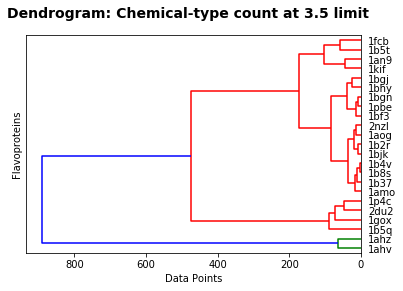

In [243]:
if __name__ == "__main__":
    main()